In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import random_split
from torch.optim.lr_scheduler import StepLR


In [2]:
orgin_raw_data_dir = 'C:\\Users\\21945\\PycharmProjects\\Hands-on-EEG\\new_implement\\data\\only_walk_3000'
model_save ='C:\\Users\\21945\\PycharmProjects\\Hands-on-EEG\\new_implement\\model'
pic_dir = 'C:\\Users\\21945\\PycharmProjects\\Hands-on-EEG\\new_implement\\pic'

In [3]:
file_list = os.listdir(orgin_raw_data_dir)
saved_path = os.getcwd()
print("Current Working Directory is " + saved_path)
os.chdir(orgin_raw_data_dir)
for file_name in file_list:
    print(file_name)
os.chdir(saved_path)

Current Working Directory is C:\Users\21945\PycharmProjects\Hands-on-EEG\new_implement\ana_code
walkbase_bke_01_epocflex_2023_window_0.csv
walkbase_bke_01_epocflex_2023_window_1.csv
walkbase_bke_01_epocflex_2023_window_10.csv
walkbase_bke_01_epocflex_2023_window_100.csv
walkbase_bke_01_epocflex_2023_window_101.csv
walkbase_bke_01_epocflex_2023_window_102.csv
walkbase_bke_01_epocflex_2023_window_103.csv
walkbase_bke_01_epocflex_2023_window_104.csv
walkbase_bke_01_epocflex_2023_window_105.csv
walkbase_bke_01_epocflex_2023_window_106.csv
walkbase_bke_01_epocflex_2023_window_107.csv
walkbase_bke_01_epocflex_2023_window_108.csv
walkbase_bke_01_epocflex_2023_window_11.csv
walkbase_bke_01_epocflex_2023_window_12.csv
walkbase_bke_01_epocflex_2023_window_13.csv
walkbase_bke_01_epocflex_2023_window_14.csv
walkbase_bke_01_epocflex_2023_window_15.csv
walkbase_bke_01_epocflex_2023_window_16.csv
walkbase_bke_01_epocflex_2023_window_17.csv
walkbase_bke_01_epocflex_2023_window_18.csv
walkbase_bke_01_e

In [4]:
labels = []
for file_name in file_list:
    labels.append(file_name.split('_')[0])

print(labels)
#print(labels[3])

label_map = { 'walkbase': 0, 'walkl': 1 ,'walkfocus': 2}

encode_labels  = [label_map[label] for label in labels]

label = torch.tensor(encode_labels, dtype=torch.int64)

['walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'walkbase', 'wa

In [5]:
class EEG_Dataset(Dataset):
    def __init__(self, data_dir,data_label):
        self.data_dir = orgin_raw_data_dir
        self.file_list = os.listdir(self.data_dir)
        self.data_label = label

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        file_path = os.path.join(self.data_dir, file_name)
        data = pd.read_csv(file_path, header=None)
        data = data.values
        data = torch.from_numpy(data)
        data_label = self.data_label[idx]
        return data, data_label

In [6]:
dataset = EEG_Dataset(orgin_raw_data_dir,label)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True)

In [7]:
class EEGNet(nn.Module):
    def __init__(self, num_classes=3):
        super(EEGNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(1, 4), stride=(1, 2))
        self.bn1 = nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.pool1 = nn.MaxPool2d(kernel_size=(1, 4), stride=(1, 4))
        self.dropout1 = nn.Dropout(p=0.25)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(1, 2), stride=(1, 2))
        self.bn2 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.pool2 = nn.MaxPool2d(kernel_size=(1, 4), stride=(1, 4))
        self.dropout2 = nn.Dropout(p=0.25)
        self.fc1 = nn.Linear(48576, 128)
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 3)


    def forward(self, x):
        x = torch.unsqueeze(x, 1)
        #print('x:', x.shape)
        x = self.conv1(x)
        #print('conv1:', x.shape)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        #print('conv2:', x.shape)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        x = x.view(x.size(0), -1)
        #print('flatten:', x.shape)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

# model = EEGNet()

In [8]:
X = torch.randn(size=( 1, 33, 3000), dtype=torch.float32)
model = EEGNet()
output = model(X)
print(output.shape)

torch.Size([1, 3])


In [9]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.cuda.is_available()
    else "cpu"
)
# device = ("cpu")
print(f"Using {device} device")


Using cuda device


In [10]:
learning_rate = 0.0001
batch_size = 64
num_epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

In [11]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred = model(X.float())
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            global train_loss
            train_loss.append(loss)



def test(dataloader, model,loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error:\n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    global valid_loss
    valid_loss.append(test_loss)
    global accuracy
    accuracy.append(correct)

In [12]:
# torch.cuda.empty_cache()
# model = model = EEG_LSTM(input_size=31000, hidden_size=128, num_layers=2,num_classes=train_class_number).to(device)
model = model.cuda()
train_loss = []
valid_loss = []
accuracy = []
for t in range(num_epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    model.train(True)
    train(train_loader, model, loss_fn, optimizer)

    model.train(False)
    test(test_loader, model, loss_fn)

print("Done!")

Epoch 1
-------------------------------
loss: 1.171773  [    0/ 1480]
loss: 0.931354  [  400/ 1480]
loss: 0.506383  [  800/ 1480]
loss: 0.236715  [ 1200/ 1480]
Test Error:
 Accuracy: 77.8%, Avg loss: 0.688069 

Epoch 2
-------------------------------
loss: 0.503025  [    0/ 1480]
loss: 0.292965  [  400/ 1480]
loss: 0.572497  [  800/ 1480]
loss: 0.975097  [ 1200/ 1480]
Test Error:
 Accuracy: 83.5%, Avg loss: 0.555602 

Epoch 3
-------------------------------
loss: 0.603103  [    0/ 1480]
loss: 0.394701  [  400/ 1480]
loss: 1.564078  [  800/ 1480]
loss: 0.334191  [ 1200/ 1480]
Test Error:
 Accuracy: 86.2%, Avg loss: 0.435202 

Epoch 4
-------------------------------
loss: 0.421936  [    0/ 1480]
loss: 0.278758  [  400/ 1480]
loss: 0.769691  [  800/ 1480]
loss: 0.203462  [ 1200/ 1480]
Test Error:
 Accuracy: 92.4%, Avg loss: 0.320260 

Epoch 5
-------------------------------
loss: 0.246437  [    0/ 1480]
loss: 0.488300  [  400/ 1480]
loss: 0.305791  [  800/ 1480]
loss: 0.134112  [ 1200/ 14

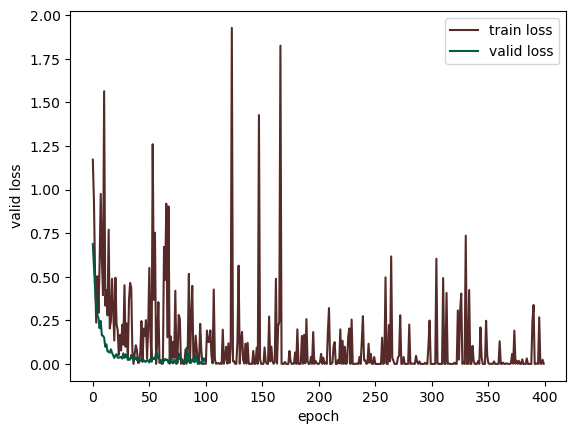

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
hex_d1 = '#552a28'
hex_d2 = '#005943'

plt.figure()
plt.plot(train_loss,hex_d1,label='train loss')
plt.ylabel('train loss')
plt.xlabel('epoch')
plt.plot(valid_loss,hex_d2,label='valid loss')
plt.ylabel('valid loss')
plt.xlabel('epoch')
plt.legend()

plt.savefig('cnn_3000_100e_loss_2.png')
plt.show()

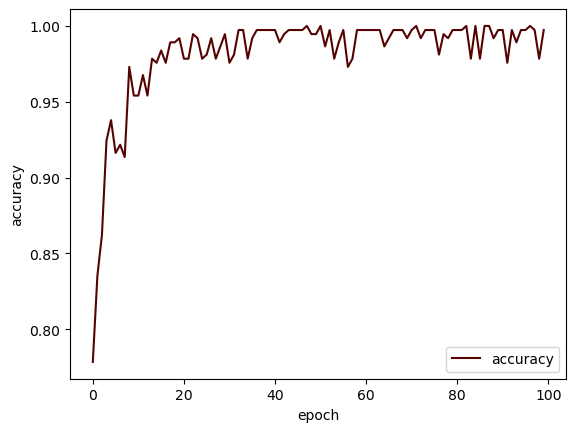

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.figure()
plt.plot(accuracy, color = '#550300', label='accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.savefig('cnn_3000_100e_accuracy_2.png')
plt.show()

In [80]:
signal = pd.read_csv("C:\\Users\\21945\\PycharmProjects\\Hands-on-EEG\\new_implement\\data\\only_walk_3000\\walkfocus_zyy_epocflex_2023_window_51.csv",header=None)
model = EEGNet()
model.eval()
input = torch.from_numpy(signal.values)
input = input.unsqueeze(0)
with torch.no_grad():
    output = model(input.float())
    # print(output)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    print(probabilities)
#
# _, pred = torch.max(output, dim=1)  # 找到预测分数最大的类别，得到预测类别
# label_map = { 0: 'walkbase', 1: 'walkl' ,2: 'walkfocus'}
# print(label_map[pred.item()])

tensor([[1.0000e+00, 3.4059e-27, 0.0000e+00]])
